In [1]:
import os
import sys

In [2]:
# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import text_recognizer.data

# Configure
emnist = text_recognizer.data.EMNIST()
print(emnist.__doc__)

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EMNIST dataset of handwritten characters and digits.

    "The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19
    and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset."
    From https://www.nist.gov/itl/iad/image-group/emnist-dataset

    The data split we will use is
    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
    


In [4]:
emnist.prepare_data()  # download, save to disk
emnist.setup()  # create torch.utils.data.Datasets, create train/val split


709MB [04:20, 2.86MB/s]                               


Computing SHA-256...
Unzipping EMNIST...
Loading training data from .mat file
Balancing classes to reduce amount of data
Saving to HDF5 in a compressed format...
Saving essential dataset parameters to text_recognizer/data...
Cleaning up...


In [5]:
x, y = next(iter(emnist.train_dataloader()))

H


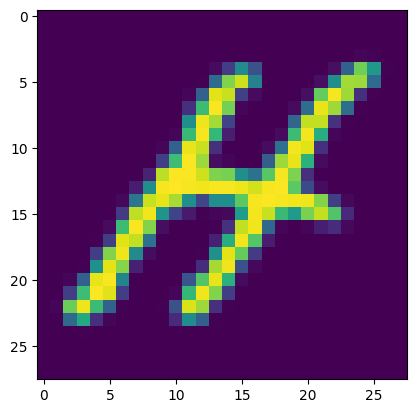

In [6]:
import random
import matplotlib.pyplot as plt


idx = random.randint(0, len(x) - 1)

print(emnist.mapping[y[idx]])
plt.imshow(x[idx].view(28,28))

In [8]:
data_config = emnist.config()

print(data_config)

{'input_dims': (1, 28, 28), 'output_dims': (1,), 'mapping': ['<B>', '<S>', '<E>', '<P>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?']}
